In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torch.utils.data as data
import torch.utils.data.sampler as sampler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import data_loader

batch_size = 100
lr = .001
dim_image = 28**2
dim_hidden = 400
dim_latent = 200
train_loader, validation_loader, test_loader = data_loader.load_mnist(batch_size=batch_size)

torch.cuda.is_available()

100%|██████████| 9912422/9912422 [00:00<00:00, 20800117.29it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29902664.48it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 15942727.45it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13976910.32it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



False

In [15]:
import torch

tensor = torch.tensor([
  [
    [1, 2, 3],
    [4, 5, 6]
  ],
  [
    [7,8,9],
    [10,11,12]
  ],
  [
    [1, 2, 3],
    [4, 5, 6]
  ],
  [
    [7,8,9],
    [10,11,12]
  ]
])
print(tensor.shape)
tensor.sum(dim=1, keepdim=True).shape

torch.Size([4, 2, 3])


torch.Size([4, 1, 3])

In [53]:
import torch

tensor = torch.tensor([
  [
    [1, 2, 3],
    [4, 5, 6]
  ],
  [
    [7,8,9],
    [10,11,12]
  ],
  [
    [1, 2, 3],
    [4, 5, 6]
  ],
  [
    [7,8,9],
    [10,11,12]
  ]
])
print(tensor.shape)
print(tensor.argmin(dim=1).shape)
print(tensor.argmin(dim=1).unsqueeze(1).shape)

torch.Size([4, 2, 3])
tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])
torch.Size([4, 3])
torch.Size([4, 1, 3])


In [17]:
tensor1 = torch.Tensor([[1],[2]])
print(tensor1.shape)
tensor2 = torch.Tensor([[1,2],[3,4]])
print(tensor2.shape)
tensor1 - tensor2

torch.Size([2, 1])
torch.Size([2, 2])


tensor([[ 0., -1.],
        [-1., -2.]])

In [50]:
tensor = torch.tensor([
1
])
print(tensor.shape)
tensor.unsqueeze(1).shape

torch.Size([1])


torch.Size([1, 1])

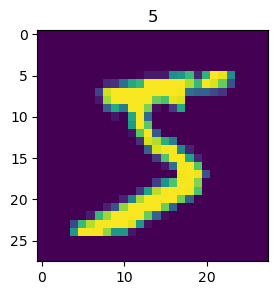

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
plt.title(f"{train_loader.dataset[0][1]}")
plt.imshow(train_loader.dataset[0][0][0])
plt.show()

In [131]:
class Encoder(nn.Module): # Gaussian MLP
  def __init__(self, dim_input, dim_hidden, dim_output):
    super(Encoder, self).__init__()
    self.L1 = nn.Linear(dim_input, dim_hidden)
    self.L_mu = nn.Linear(dim_hidden, dim_output)
    self.L_sig = nn.Linear(dim_hidden, dim_output)
    
  def forward(self, x):
    _h = self.L1(x)
    _h = functional.tanh(_h)
    mu = self.L_mu(_h)
    log_var = self.L_sig(_h)
    return mu, log_var

In [132]:
class Decoder(nn.Module): # Bernoulli MLP
  def __init__(self, dim_input, dim_hidden, dim_output):
    super(Decoder, self).__init__()
    self.L1 = nn.Linear(dim_input, dim_hidden)
    self.L2 = nn.Linear(dim_hidden, dim_output)
    
  def forward(self, z):
    _h = self.L1(z)
    _h = self.L2(functional.tanh(_h))
    return functional.sigmoid(_h)

In [133]:
class Model(nn.Module):
  def __init__(self, encoder: Encoder, decoder: Decoder):
    super(Model, self).__init__()
    self.Encoder = encoder
    self.Decoder = decoder
  
  @staticmethod
  def reparameterization(mu, sig_sqrd):
    epsilon = torch.randn_like(sig_sqrd)
    return mu + sig_sqrd * epsilon
  
  def forward(self, x):
    mu, log_var = self.Encoder(x)
    z = self.reparameterization(mu, torch.exp(1/2 * log_var))
    return self.Decoder(z), mu, log_var
    

In [134]:
encoder = Encoder(dim_image, dim_hidden, dim_latent)
decoder = Decoder(dim_latent, dim_hidden, dim_image)
model = Model(encoder, decoder)

print(model)

Model(
  (Encoder): Encoder(
    (L1): Linear(in_features=784, out_features=400, bias=True)
    (L_mu): Linear(in_features=400, out_features=200, bias=True)
    (L_sig): Linear(in_features=400, out_features=200, bias=True)
  )
  (Decoder): Decoder(
    (L1): Linear(in_features=200, out_features=400, bias=True)
    (L2): Linear(in_features=400, out_features=784, bias=True)
  )
)


In [135]:
def elbo_loss(x, x_hat, mu, log_var):
  kl_div = - 1/2 * torch.sum(1 + log_var - torch.pow(mu, 2) - torch.exp(log_var))
  reconx_los = functional.binary_cross_entropy(x_hat, x, reduction='sum')
  return reconx_los + kl_div

In [136]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)

epochs = 30

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    total_loss = 0.
    
    for i, (X, y) in enumerate(train_loader):
        model.train()
        X = X.view(batch_size, 784)
        X_hat, mu, log_var = model(X) # training mode
        loss = elbo_loss(X, X_hat, mu, log_var)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    print(f"training loss: {total_loss / len(train_loader)}")
        

epoch 0
training loss: 18267.773541666666
epoch 1
training loss: 14295.317200520833
epoch 2
training loss: 12676.204057617188
epoch 3
training loss: 11975.347032877604
epoch 4
training loss: 11633.227942708334
epoch 5
training loss: 11411.083688151042
epoch 6
training loss: 11257.744627278646
epoch 7
training loss: 11143.522491861979
epoch 8
training loss: 11049.138929036459
epoch 9
training loss: 10969.217565104167
epoch 10
training loss: 10900.072845052084
epoch 11
training loss: 10843.89288248698
epoch 12
training loss: 10794.30819986979
epoch 13
training loss: 10752.470257161458
epoch 14
training loss: 10716.816227213541
epoch 15
training loss: 10679.728009440105
epoch 16
training loss: 10655.726821289063
epoch 17
training loss: 10628.322662760416
epoch 18
training loss: 10598.911155598958
epoch 19
training loss: 10581.745428059896
epoch 20
training loss: 10562.452503255208
epoch 21
training loss: 10548.906430664063
epoch 22
training loss: 10534.127373046875
epoch 23
training loss:

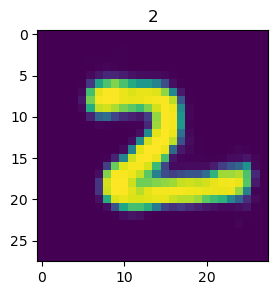

In [137]:
z_test = []
with torch.no_grad():
  for j, (test_X, test_y) in enumerate(test_loader):
    test_X = test_X.view(1, 784)
    z, _, _ = model(test_X)
    z_test.append((z.view(28, 28), test_y))

plt.figure(figsize=(3, 3))
plt.title(f"{z_test[0][1].item()}")
plt.imshow(z_test[0][0])
plt.show()